# M2HATS Data Comparison (from Zarr)
### Purpose
Replicate a preexisting M2HATS data comparison workflow using Zarr stores, rather than individual netcdf files.

### Data
The two datasets used in this example are ERA5 reanalysis on pressure levels and 30-minute 449MHz Wind Profiler data. Both datasets have been saved as Zarr stores in Step 1 of this workflow. 

### Motivation
To assess the feasability and usability of Zarr stores in targeted analysis from an EOL field campaign.

### Audience
Any researcher or PI interested in performing analyses using EOL's in-situ data, who is looking to modernize their workflow.

---

## Import required packages

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

---

## Read in zarr stores

In [2]:
lustre_scratch = "/lustre/desc1/scratch/myasears"

In [8]:
era5_zarr = xr.open_zarr(f"{lustre_scratch}/2023_M2HATS/era5_M2HATS_ISS1_heights.zarr")
prof449Mhz_zarr = xr.open_zarr(f"{lustre_scratch}/2023_M2HATS/prof449_M2HATS_ISS1_winds30.zarr")

---

## Align datasets

#### 449 interpolation
Interpolate the 449MHz profiler dataset (referred to as "449") onto the ERA5 time grid.


In [9]:
prof449Mhz_zarr = prof449Mhz_zarr.interp(time=era5_zarr['time'])

#### ERA5 interpolation
Completed in pre-processing; the ERA5 Reanalysis Zarr store associated with this project (referred to as "ERA5") has been created using height coordinates instead of default pressure levels. 

---

## Compare datasets
Visualize and calculate the differences between ERA5 and 449 on the same height and time level for the entire M2HATS field campaign. 

### Scatter plot
This first plotting section directly compares ERA5 and 449 data points from the same time and height level, using all non-nan data from the entire field campaign. This shows us the approximate alignment of the model and profiler dataset.

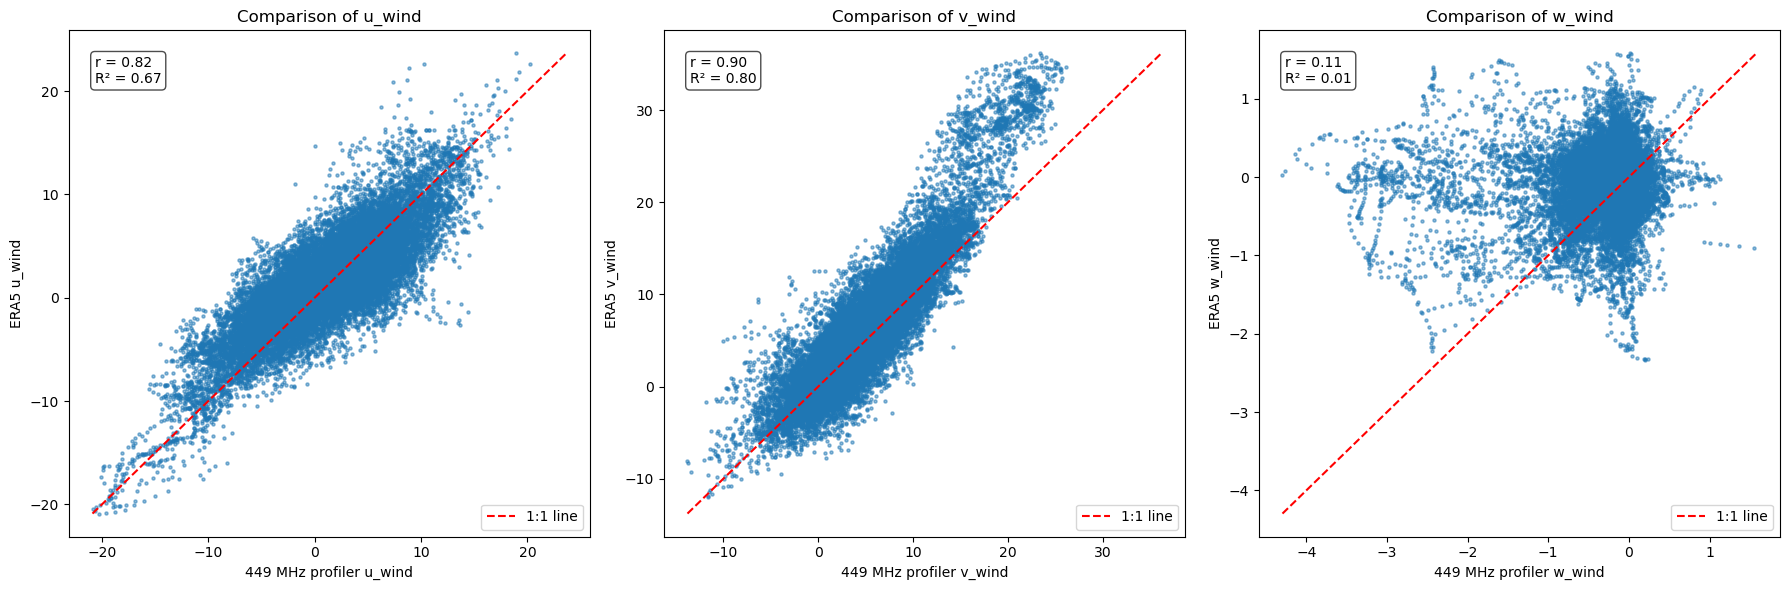

In [12]:
vars_to_compare = ["u_wind", "v_wind", "w_wind"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, var in zip(axes, vars_to_compare):
    # Extract values aligned on (time, height_msl)
    x = prof449Mhz_zarr[var].values.ravel()
    y = era5_zarr[var].values.ravel()

    # Mask NaNs
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]

    # Scatter plot
    ax.scatter(x, y, s=5, alpha=0.5)

    # Add x=y reference line
    lims = [min(x.min(), y.min()), max(x.max(), y.max())]
    ax.plot(lims, lims, "r--", label="x=y line")

    # Correlation and R²
    if len(x) > 1:
        r = np.corrcoef(x, y)[0, 1]
        r2 = r**2
        ax.text(
            0.05, 0.95,
            f"r = {r:.2f}\nR² = {r2:.2f}",
            transform=ax.transAxes,
            va="top", ha="left",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
        )

    ax.set_xlabel(f"449 MHz profiler {var}")
    ax.set_ylabel(f"ERA5 {var}")
    ax.set_title(f"Comparison of {var}")
    ax.legend()

plt.tight_layout()
plt.show()

**Horizontal winds:**       
From this visual comparison, it's clear that u winds and v winds are generally comparable between the ERA5 model and 449 data, as the scatter points approximately follow the x=y line. Additionally, the R^2 values are sufficiently high enough that we suspect that ERA5 will be a good comparison tool for many weather scenarios during this campaign; we will look into specific points of divergence in the next step.       

**Vertical winds:**       
Both the shape of the w winds plot and its associated R^2 values indicate significant differences between observed and modeled data for this field campaign. We will attempt to identify specific points of divergence during the next step, which might allow us to find scenarios where the ERA5 model and the 449 data agree. Also worth noting: this notebook only provides a case study between two sources. If we were performing a full field campaign analysis, we would bring in an additional 4+ data sources to further understand the source of the differences seen between ERA5 and 449 vertical winds.

### Attribution plot
This second section attempts to understand where the differences between ERA5 and 449 data points arise, exploring the (averaged) mean absolute error (MAE) between the two aligned datasets on: each day of the field campaign, each hour of the day, and each height level. The division of MAE between these variables allows us to identify any consistent or anomalous errors.        

**For example:** the daily MAE plot can indicate specific high-error days, such as a hurricane passage, that caused error rates to spike. The hourly MAE plot can suggest times of day where error is anomalously high, such as during the night. The height levels MAE can allude to errors in space, such as a disagreement between surface wind magnitudes. 

In [38]:
# Can delete this once included in the zarr
import metpy.calc as mpcalc
from metpy.units import units

u = era5_zarr["u_wind"].data * units("m/s")
v = era5_zarr["v_wind"].data * units("m/s")

u_ = u.compute()
v_ = v.compute()

wspd = mpcalc.wind_speed(u, v).m
wdir = mpcalc.wind_direction(u_, v_, convention="from").m

era5_zarr["wspd"] = (("time", "height_msl"), wspd)
era5_zarr["wdir"] = (("time", "height_msl"), wdir)

/glade/derecho/scratch/myasears/tmp/ipykernel_32692/1989137069.py:27: RuntimeWarning: Mean of empty slice
  mae_height = np.nanmean(err, axis=0)  # mean over time dimension


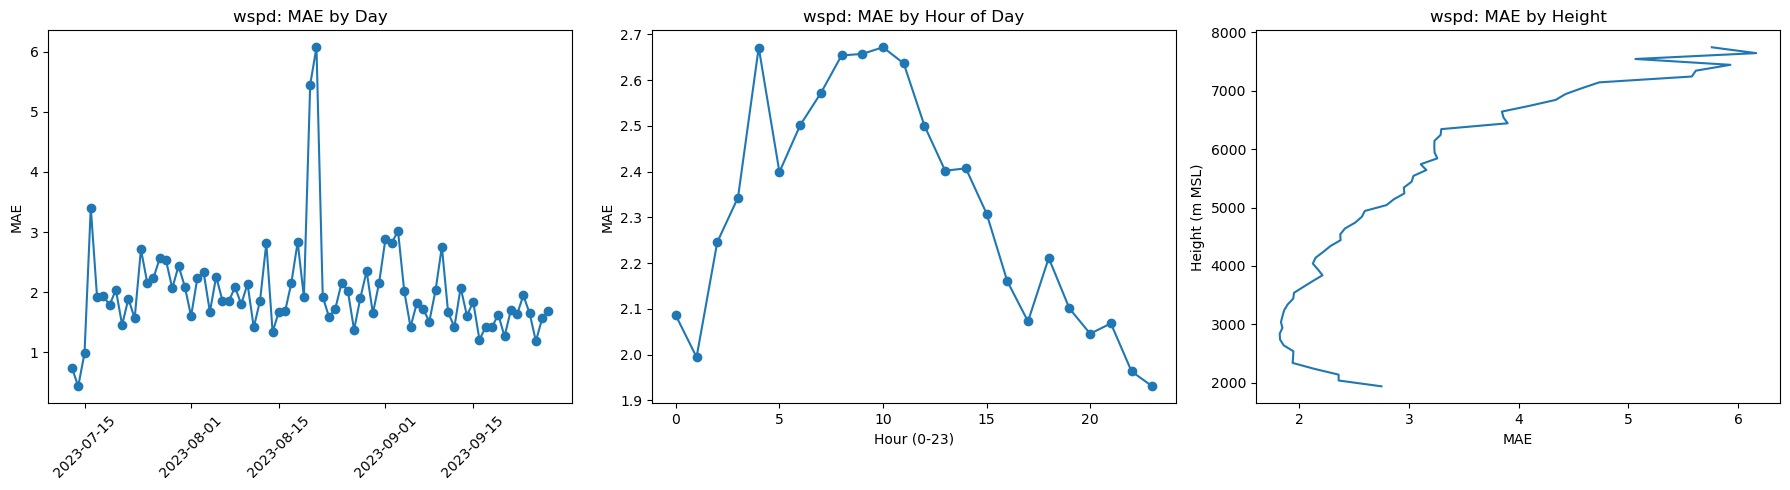

/glade/derecho/scratch/myasears/tmp/ipykernel_32692/1989137069.py:27: RuntimeWarning: Mean of empty slice
  mae_height = np.nanmean(err, axis=0)  # mean over time dimension


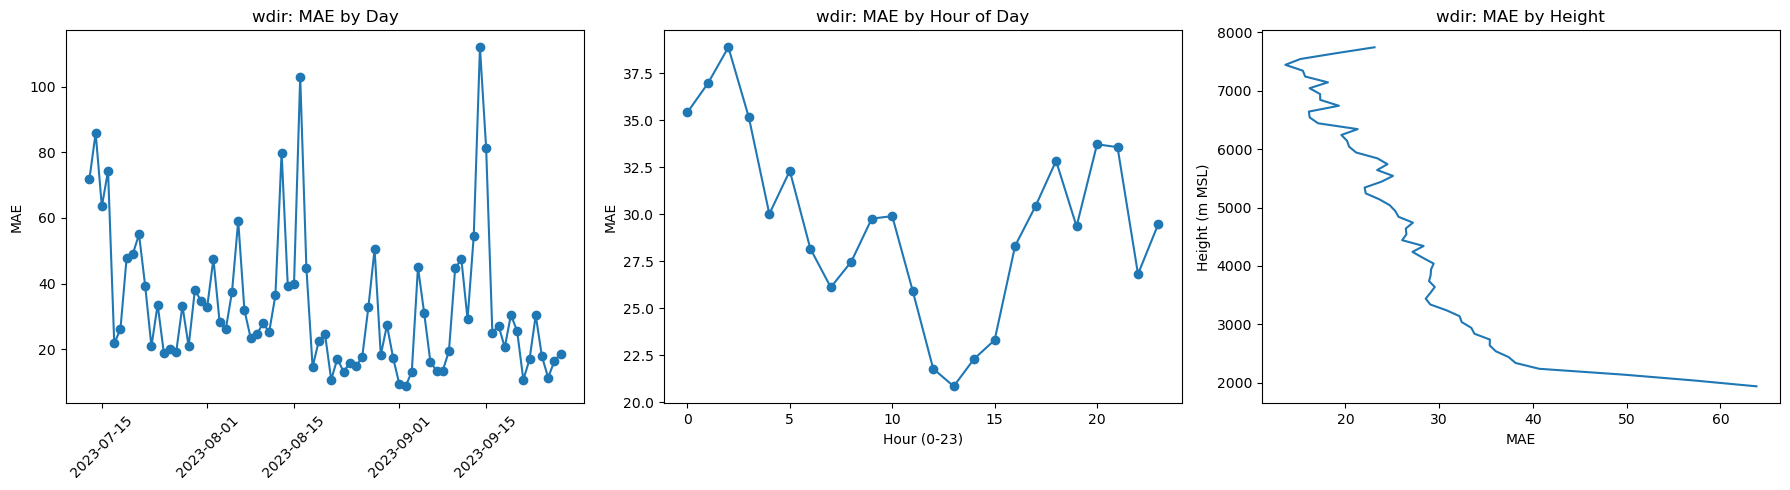

/glade/derecho/scratch/myasears/tmp/ipykernel_32692/1989137069.py:27: RuntimeWarning: Mean of empty slice
  mae_height = np.nanmean(err, axis=0)  # mean over time dimension


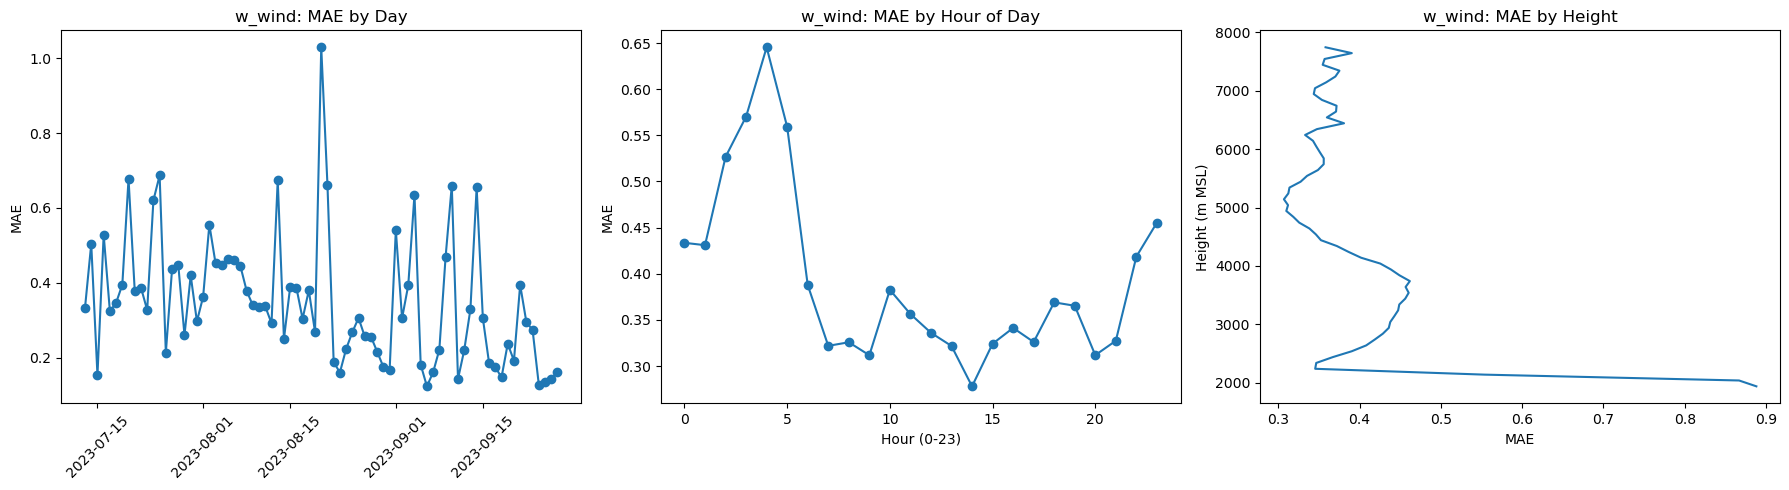

In [40]:
vars_to_compare = ["wspd", "wdir", "w_wind"]

for var in vars_to_compare:
    # Load arrays eagerly
    arr1 = prof449Mhz_zarr[var].values
    arr2 = era5_zarr[var].values
    time = prof449Mhz_zarr["time"].values
    height = prof449Mhz_zarr["height_msl"].values

    # Compute absolute error (NumPy array)
    err = np.abs(arr1 - arr2)

    # --- (1) Daily MAE ---
    # collapse height dimension, then average by day
    df_daily = pd.DataFrame({
        "time": np.repeat(time, len(height)),
        "err": err.reshape(len(time) * len(height)),
    })
    df_daily["day"] = pd.to_datetime(df_daily["time"]).dt.date
    mae_daily = df_daily.groupby("day")["err"].mean()

    # --- (2) Hour-of-day MAE ---
    df_daily["hour"] = pd.to_datetime(df_daily["time"]).dt.hour
    mae_hourly = df_daily.groupby("hour")["err"].mean()

    # --- (3) Height MAE ---
    mae_height = np.nanmean(err, axis=0)  # mean over time dimension

    # --- Plot ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Daily
    axes[0].plot(mae_daily.index, mae_daily.values, marker="o")
    axes[0].set_title(f"{var}: MAE by Day")
    axes[0].set_ylabel("MAE")
    axes[0].tick_params(axis="x", rotation=45)

    # Hour-of-day
    axes[1].plot(mae_hourly.index, mae_hourly.values, marker="o")
    axes[1].set_title(f"{var}: MAE by Hour of Day")
    axes[1].set_xlabel("Hour (0-23)")
    axes[1].set_ylabel("MAE")

    # Height
    axes[2].plot(mae_height, height)
    axes[2].set_title(f"{var}: MAE by Height")
    axes[2].set_xlabel("MAE")
    axes[2].set_ylabel("Height (m MSL)")

    plt.tight_layout()
    plt.show()

**MAE by day:**

**MAE by hour:**

**MAE by height:**